In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

In [141]:
def p(k, i, xi, A, a, h, k2coord, Gt):
    return 1 / (1 + math.exp(-2 * I(k, i, xi, A, a, h, k2coord, Gt)))

def I(k, i, xi, A, a, h, k2coord, Gt):
    total = 0
    zeta = random.uniform(-1,1)  # sampled for each unique (k,i)
    for j in k2coord[k]:  # for each coordinate in cluster k
        eta = random.uniform(-1,1)  # different for each cell
        sigma = Gt[j]
        total += ((A*xi[k] + a*eta) * sigma) + h*zeta
    return (1 / len(k2coord[k])) * total

def cluster_info(arr):
    """ number of clusters (nonzero fields separated by 0s) in array
        and size of cluster
    """
    data = []
    k2coord = {}
    k = 0
    if arr[0] != 0: # left boundary
        data.append(0) # we will increment later in loop  
        k2coord[k] = []
    else:
        k=-1

    # print("arr", arr)
    # print("data", data)
    
    for i in range(0,len(arr)-1):
        if arr[i] == 0 and arr[i+1] != 0:
            data.append(0)
            k += 1
            k2coord[k] = []
        if arr[i] != 0:
            data[-1] += 1
            k2coord[k].append(i)
    if arr[-1] != 0:
        if data:  # if array is not empty
            data[-1] += 1  # right boundary
            k2coord[k].append(len(arr)-1)
        else:
            data.append(1)  
            k2coord[k] = [len(arr)-1]
            
    Ncl = len(data)  # number of clusters
    Nk = data  # Nk[k] = size of cluster k
    coord2k = {e:k for k,v in k2coord.items() for e in v}
    return Ncl, Nk, k2coord, coord2k

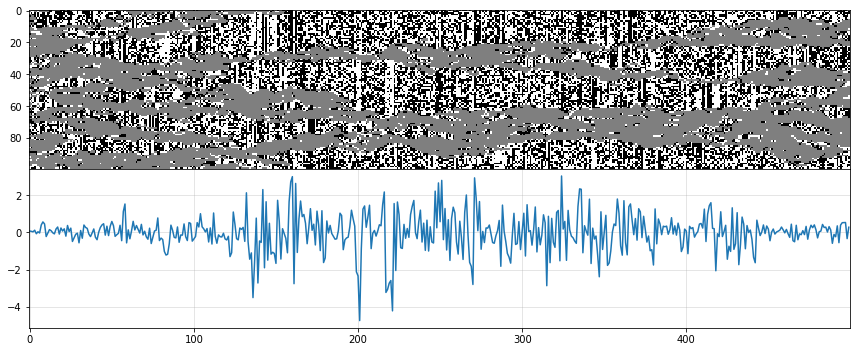

In [142]:
pd = 0.25
pe = 0.02
ph = 0.2 # vary

pa = 0.5

N0 = 500
N1 = 100

A = 2
a = 0.1
h = 0.1

G = np.zeros(shape=(N0,N1)).astype(int)
G[0] = np.random.choice(a=[-1,0,1], p=[pa/2, 1-pa, pa/2], size=N1, replace=True)

x = np.empty(N0)

for t in range(N0):
    Ncl, Nk, k2coord, coord2k = cluster_info(G[t])
    xi = np.random.uniform(-1, 1, size=Ncl)  # unique xi for each cluster k
    # print(Ncl, Nk, k2coord, coord2k, xi)

    xt = 0
    for k, size in enumerate(Nk):
        tmp = 0
        for i in k2coord[k]:
            tmp += G[t,i]
        xt += size * tmp
    x[t] = xt

    if t == N0-1:
        # last iteration, we stop
        break

    for i in range(N1):
        # traders update their stance
        if G[t,i] != 0:
            k = coord2k[i]
            # print(k)
            pp = p(k, i, xi, A, a, h, k2coord, G[t])
            if random.random() < pp:
                G[t+1,i] = 1
            else:
                G[t+1,i] = -1

        
        # trader influences non-active neighbour to join
        if G[t,i] != 0:
            stance = G[t,i]
            if random.random() < ph:
                if G[t,(i-1)%N1] == 0 and G[t,(i+1)%N1] == 0:
                    ni = random.choice([-1,1])
                    G[t+1,(i+ni)%N1] = stance#random.choice([-1,1])
                elif G[t,(i-1)%N1] == 0:
                    G[t+1,(i-1)%N1] = stance#random.choice([-1,1])
                elif G[t,(i+1)%N1] == 0:
                    G[t+1,(i+1)%N1] = stance#random.choice([-1,1])
                else:
                    continue

        # active trader diffuses if it has inactive neighbour
        # only happens at edge of cluster
        if G[t,i] != 0:
            if random.random() < pd:
                if (G[t,(i-1)%N1] == 0) or (G[t,(i+1)%N1] == 0):
                    G[t+1,i] = 0
                else:
                    continue

        # nontrader enters market
        if G[t,i] == 0:
            if random.random() < pe:
                G[t+1,i] = random.choice([-1,1])

fig, (ax1, ax2) = plt.subplots(
    ncols=1, nrows=2, figsize=(12,5), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}
)
ax1.imshow(G.T, cmap="binary", interpolation="None", aspect="auto")
# plt.colorbar()

r = (x - np.mean(x)) / np.std(x)
ax2.plot(r)
ax2.grid(alpha=0.4)

plt.tight_layout()
plt.show()